# IMAGE WARPING and MOSAICING

In [1]:
import cv2

import numpy as np
import skimage.io as skio
from matplotlib import pyplot as plt

from skimage.draw import polygon
from Utils.ImagePointSet import ImagePointSet
from scipy.interpolate import griddata
from Utils.raw_image_operations import save_image

## Recover Homographies

In [34]:
def compute_projection_matrix(src_points, dest_points):
    if len(src_points) < 4 or len(dest_points) < 4:
        raise ValueError("At least 4 points are required.")
    if src_points.shape != dest_points.shape:
        raise ValueError("Input arrays must have the same shape.")
    
    x, y = src_points[:, 0], src_points[:, 1]
    x_prime, y_prime = dest_points[:, 0], dest_points[:, 1]
    
    zeros = np.zeros(x.shape)
    ones = np.ones(x.shape)
    
    A1 = np.column_stack((-x, -y, -ones, zeros, zeros, zeros, x*x_prime, y*x_prime, x_prime))
    A2 = np.column_stack((zeros, zeros, zeros, -x, -y, -ones, x*y_prime, y*y_prime, y_prime))
    
    A = np.row_stack((A1, A2))

    _, _, vh = np.linalg.svd(A)
    homography_matrix = vh[-1].reshape(3, 3)
    
    return homography_matrix

# Used to verify method
def wrap_image_with_cv2(image, projection_matrix):
    h, w, _ = image.shape
    output_size = (w, h)
    
    wrapped_image = cv2.warpPerspective(image, projection_matrix, output_size)
    
    return wrapped_image

def warp_image(image, projection_matrix):
    h, w, _ = image.shape
    x = np.linspace(0, w-1, w)
    y = np.linspace(0, h-1, h)
    x, y = np.meshgrid(x, y)
    homogenous_coords = np.vstack((x.flatten(), y.flatten(), np.ones(x.size)))
    
    warped_homogenous_coords = np.dot(np.linalg.inv(projection_matrix), homogenous_coords)
    warped_coords = warped_homogenous_coords / warped_homogenous_coords[2]
    
    # warped_x_min, warped_y_min = np.min(warped_coords[0]), np.min(warped_coords[1])
    # warped_x = warped_coords[0] - warped_x_min if warped_x_min < 0 else warped_coords[0]
    # warped_y = warped_coords[1] - warped_y_min if warped_y_min < 0 else warped_coords[1]
    
    warped_x = warped_coords[0]
    warped_y = warped_coords[1]
    
    warped_image = griddata(
        (homogenous_coords[0], homogenous_coords[1]),
        image.reshape(-1, 3),
        (warped_x, warped_y),
        method='cubic',
        fill_value=0
    )
    
    return warped_image.reshape(h, w, 3)

In [35]:
hallway0_hallway1 = ImagePointSet("hallway/hallway1_hallway2.json")
hallway0_hallway1_projection_matrix = compute_projection_matrix(hallway0_hallway1.points[0], hallway0_hallway1.points[1])
warped_hallway0_hallway1_image = warp_image(hallway0_hallway1.images[0], hallway0_hallway1_projection_matrix)

ipad_image_set = ImagePointSet("ipad_ipad.json")
ipad_image_set_matrix = compute_projection_matrix(ipad_image_set.points[0], ipad_image_set.points[1])
rectified_ipad_image = warp_image(ipad_image_set.images[0], ipad_image_set_matrix)
save_image(rectified_ipad_image, "rectified_ipad_image")

hallway1_rectify_image_set = ImagePointSet("hallway/hallway4_rectify.json")
hallway1_rectify_set_matrix = compute_projection_matrix(hallway1_rectify_image_set.points[0], hallway1_rectify_image_set.points[1])
rectified_hallway1_rectify_image = warp_image(hallway1_rectify_image_set.images[0], hallway1_rectify_set_matrix)
save_image(rectified_hallway1_rectify_image, "rectified_hallway4_rectify_image")


_, axes = plt.subplots(3, 3, figsize=(8, 3))
axes[0, 0].imshow(hallway0_hallway1.images[0])
axes[0, 1].imshow(ipad_image_set.images[0])
axes[0, 2].imshow(hallway1_rectify_image_set.images[0])
axes[1, 0].imshow(warped_hallway0_hallway1_image)
axes[1, 1].imshow(rectified_ipad_image)
axes[1, 2].imshow(rectified_hallway1_rectify_image)
axes[2, 0].imshow(wrap_image_with_cv2(hallway0_hallway1.images[0], hallway0_hallway1_projection_matrix))
axes[2, 1].imshow(wrap_image_with_cv2(ipad_image_set.images[0], ipad_image_set_matrix))
axes[2, 2].imshow(wrap_image_with_cv2(hallway1_rectify_image_set.images[0], hallway1_rectify_set_matrix))

In [25]:
# def blend_to_mosaic(image_list, points_list, base_image_index=None):
#     if base_image_index is None:
#         base_image_index == len(image_list) // 2
    

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


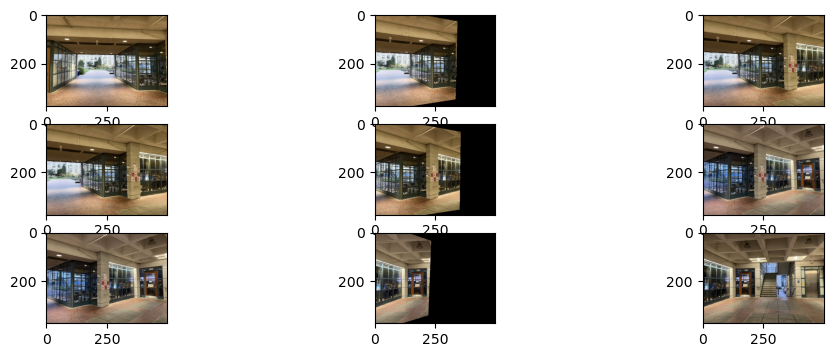

In [26]:
hallway_point_sets = [
    ImagePointSet("hallway/hallway1_hallway2.json"),
    ImagePointSet("hallway/hallway2_hallway3.json"),
    ImagePointSet("hallway/hallway3_hallway4.json")
]
for set in hallway_point_sets:
    set.align_all_points()

hallway_projection_matrix_list = [compute_projection_matrix(pt_set.points[0], pt_set.points[1]) for pt_set in hallway_point_sets]
warped_hallway_projections = [warp_image(pt_set.images[0], proj_matrix) for pt_set, proj_matrix in zip(hallway_point_sets, hallway_projection_matrix_list)]

mosaic_seq = []
for image_point_set, warped_image in zip(hallway_point_sets, warped_hallway_projections):
    seq_set = (image_point_set.images[0], warped_image, image_point_set.images[1])
    mosaic_seq.append(seq_set)

_, axes = plt.subplots(len(mosaic_seq), 3, figsize=(12, 4))
for i in range(len(mosaic_seq)):
    axes[i, 0].imshow(mosaic_seq[i][0])
    axes[i, 1].imshow(mosaic_seq[i][1])
    axes[i, 2].imshow(mosaic_seq[i][2])
        

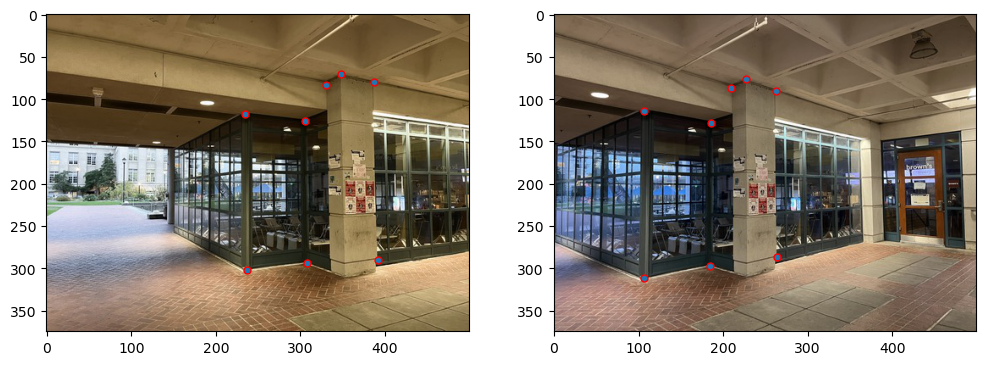

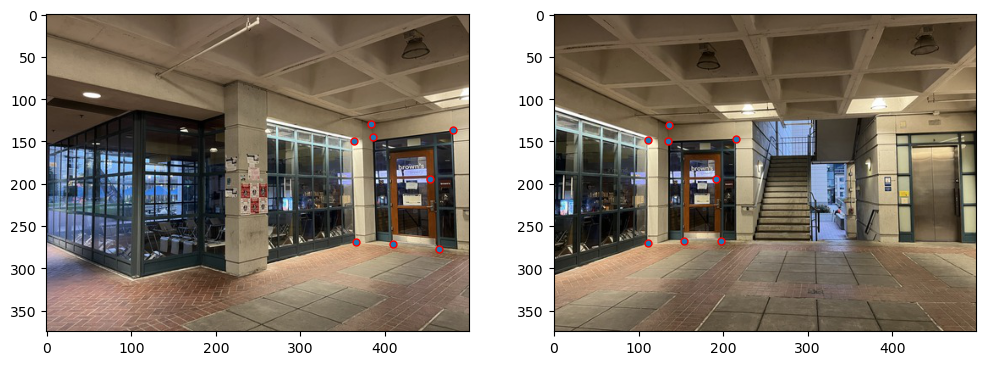

In [20]:
hallway_point_sets[1].display(True)
hallway_point_sets[2].display(True)


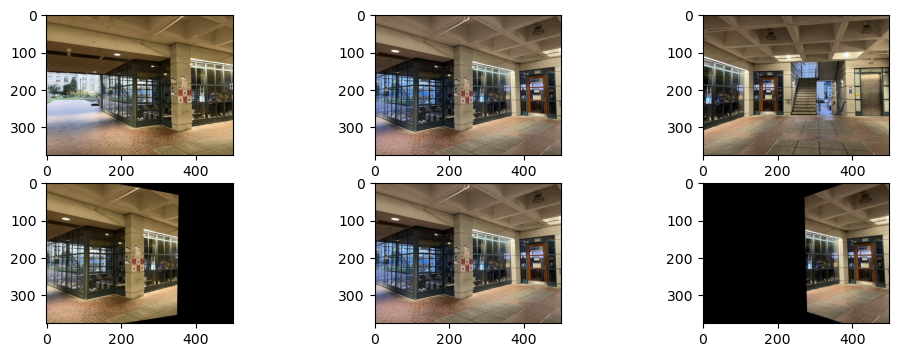

In [27]:
left_mosaic, center_mosaic, right_mosaic = hallway_point_sets[1].images[0], hallway_point_sets[1].images[1], hallway_point_sets[2].images[1]
left_points, right_points = hallway_point_sets[1].points[0], hallway_point_sets[2].points[1]
left_2_center_points = hallway_point_sets[1].points[1]
right_2_center_points = hallway_point_sets[2].points[0]

left_2_center_matrix, right_2_center_matrix = compute_projection_matrix(left_points, left_2_center_points), compute_projection_matrix(right_points, right_2_center_points)

warped_left_mosaic = warp_image(left_mosaic, left_2_center_matrix)
warped_right_mosaic = warp_image(right_mosaic, right_2_center_matrix)

_, axes = plt.subplots(2, 3, figsize=(12, 4))
axes[0, 0].imshow(left_mosaic)
axes[0, 1].imshow(center_mosaic)
axes[0, 2].imshow(right_mosaic)
axes[1, 0].imshow(warped_left_mosaic)
axes[1, 1].imshow(center_mosaic)
axes[1, 2].imshow(warped_right_mosaic)